# 蓝色边缘程序使用pandas的改写

_由于有一些星表中包含缺省项，我们需要使用pandas中使用dataframe读取csv中自动将缺省项补上的优势，来优化我们的自动化程式_

_(fits的文件我们可以使用topcat改变格式并且给星表瘦身，以加快程序读取速度）_

我们需要实现的功能包含以下几点：

输入：
* csv星表**_的名字_**
* 需要画的色指数的两个测光点（比如 $ J - H $ 我们需要输入$J$ 和 $H$）

程序中自带（我们所需要限定的条件）
_写在其中的某一个cell中作为 filt 条件_
* 限定的误差范围（测光数据一般选择 0.3，光谱数据可以具体再定，基本上认为不太离谱的都可以用）
* 去掉错误的点（见之前的程序)

输出：
* 颜色-teff 图

Now,trying:
* SFD: 一个新的ratio,比如说0.05，把这个ratio底下的部分输入进SFD,判断：E(B-V) <0.3 的值就是我们零消光的值。这个值去拟合一个新的curve。

In [106]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime
%matplotlib inline

data_dir = '/Users/SY/Desktop/obic/data/'
#data_dir = '/Users/dengdingshan/Documents/data/obic/'

In [107]:
#read as pandas
starcatalog_fram = pd.read_csv(data_dir + 'lamost_sdss_new2.csv')

###########

#starcatlog_fram = starcatlog_fram.ix[:,:517]
#print(starcatalog_fram)

In [108]:
#read parsec
parsec_fram = pd.read_csv(data_dir + 'parsec_fnugriz.csv')

############

#print(parsec_fram.values)

In [109]:
### Elective CHOICE

########### I.
#change logTeff into Teff.

# def tenn(x):
#     y=10 ** x
#     return y

# Teff_tbl = starcatalog['logTeff'].apply(tenn)
###########

########### II.
#add [Teff] into DATAFRAME

#data_fram = starcatalog_fram[['TEFF_1','ERR_TEFF_1','Jmag_1','e_Jmag_1','Hmag_1','e_Hmag_1']]
#print(data_fram)
###########

########### III.
# fill the NaN blocks with 0

starcatalog_fram_fil = starcatalog_fram.fillna(0)

#print(starcatalog_fram_fil['LOGG'])
############


In [110]:
starcatalog_fram_fil.columns

Index(['col1', 'TEFF', 'ERR_TEFF', 'RA', 'DEC', 'LOGG', 'ERR_LOGG', 'RAdeg',
       'DEdeg', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'objID', 'mode',
       'q_mode', 'class', 'SDSS12', 'm_SDSS12', 'flags', 'ObsDate', 'Q',
       'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag',
       'zmag', 'e_zmag', 'zsp', 'e_zsp', 'f_zsp', 'zph', 'e_zph', 'avg_zph',
       'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'SpObjID', 'spType', 'spCl',
       'subClass', 'angDist'],
      dtype='object')

In [128]:
### variables

teff = 'TEFF'

color1 = 'gmag'
color2 = 'rmag'
err_teff = 'ERR_TEFF'

err_c1 = 'e_' + color1
#'e_' + color1
#color1 + 'err' 
#color1 + 'err'
#ERR_' + color1
#'e_' + color1

err_c2 = 'e_' + color2
#'ERR_' + color2
#'e_' + color2

In [129]:
### we just need the mainsquence (dwarf stars)

# #judge logg >3.7

starcatalog_fram_fil = starcatalog_fram_fil[(starcatalog_fram_fil['LOGG']>3.5)]
parsec_fram = parsec_fram[(parsec_fram['logg']>3.5)]                                            

In [130]:
### get the good stars

# judge  data
starcatalog_fram_fil=starcatalog_fram_fil[((starcatalog_fram_fil[err_c1] != 0) \
                                          & (starcatalog_fram_fil[err_c2] != 0)\
                                          & (starcatalog_fram_fil[err_c1] != -99) \
                                          & (starcatalog_fram_fil[err_c2] != -99))\
                                         & ((starcatalog_fram_fil[color1] != 0)\
                                           & (starcatalog_fram_fil[color2] != 0)\
                                           & (starcatalog_fram_fil[color1] != -99) \
                                           & (starcatalog_fram_fil[color2] != -99))\
                                         &((starcatalog_fram_fil[err_c1] <=0.05)\
                                          & (starcatalog_fram_fil[err_c2] <=0.05))]
### additional judgement

# starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[err_c1] <=0.2)\
#                                            &(starcatalog_fram_fil[err_c2] <=0.05)]

print(starcatalog_fram_fil.iloc[:,0].size)

10236


In [131]:
### draw the png of errTeff 

# plt.figure(3)
# plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
# plt.ylabel('$σ_\mathrm{Teff}$',fontsize=14)
# plt.scatter(starcatalog_fram_fil[teff],starcatalog_fram_fil[err_teff],\
#             c='steelblue',s=8, edgecolors='None',alpha=0.2,label='$σ_\mathrm{Teff}$(LAMOST)')
# plt.legend(loc='lower right')
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig(savename3,dpi=200)  
# plt.show()

### 

In [132]:
# cut source g-r:0.440
origin = starcatalog_fram_fil
starcatalog_fram_fil=starcatalog_fram_fil[(starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2]>= -0.440)\
                                         & (starcatalog_fram_fil[color1]>=12)]

In [133]:
#filt the good one
#apogee_tbl_fil = apogee_tbl[np.argwhere(np.logical_and(apogee_tbl['teff'] > 0, apogee_tbl['logg'] > -3))]
#apogee_tbl_fil = apogee_tbl_fil[np.argwhere(np.logical_and(apogee_tbl_fil['j'].flatten() > -1, \
#                                                           apogee_tbl_fil['h'].flatten() > -1))]
#USE goodOB 


starcatalog_fram_fil=starcatalog_fram_fil[(((starcatalog_fram_fil[err_teff] != 0 )\
                                          & (starcatalog_fram_fil[teff]>= 10000))\
                                          #& (starcatalog_fram_fil[teff]<= 16000))
                                          & (((starcatalog_fram_fil[err_teff]< 630)\
                                          &(starcatalog_fram_fil[teff]> 9000))\
                                          |((starcatalog_fram_fil[err_teff]< 500)\
                                          & (starcatalog_fram_fil[teff]<= 9000))))]
print(np.max(starcatalog_fram_fil[teff]))

24683.125


In [134]:
# Determine the input numbers.

# Bin width, usually 50 (for more scatter, try 1000 or other figures)
#bin_width = 1000

# Ratio of the bluest edge, usually 5%
rat = 5

# Low end criteria. If the number in a bin is lower than this number then neglect.  
low_crit = 50

In [135]:
# input the data of Bessell. M.S. & Brett. J.M. 1988
# BBFrame is the dataframe of the ic data 

BBFrame=pd.DataFrame({'J-H':[-0.09,-0.08,-0.07,-0.06,-0.05,-0.03,-0.03,-0.01,0.0,0.02,0.06],\
                      'Teff':[22300,19000,17200,15400,14100,13000,11800,10700,9480,8810,8160]})


In [136]:
# parsec point
parsecframe = parsec_fram[((parsec_fram['Age'] == 3980000)\
                           &(parsec_fram['logTe'] <= 4.361)\
                           &(parsec_fram['logTe'] >= 4.000))]
parsec_teff =10**parsecframe['logTe'] 
parsec_color = parsecframe[color1] - parsecframe[color2]
#print(parsecframe.values)
                                         

In [137]:
# Find the start point and bin number of Teff. 
# Start point: the first number divisible by bin_width smaller than min(teff)
# Bin number: Start from start point and cover all the teff range.


#teff_start = min(apogee_tbl_fil['teff']) - min(apogee_tbl_fil['teff']) % (bin_width/2)
#bin_number = math.ceil((max(apogee_tbl_fil['teff']) - teff_start) / bin_width)

#teff_start = min(starcatalog_fram_fil[teff])-min(starcatalog_fram_fil[teff])%(bin_width / 2)

teff_start= 10000

#bin_number = math.ceil((max(starcatalog_fram_fil[teff])-teff_start) / bin_width)


In [138]:
#filt BBFrame
BBFrame_fil=BBFrame[BBFrame['Teff'] >= teff_start]

In [139]:
def data(teff_start,ratio,low_crit,ratio_SFD):
    
    start_time = time.time()
    int_teff = []
    int_color = []
    bin_int_color = []
    
    SFD_RA = []; SFD_DEC = []; SFD_TEFF = []; SFD_color1 = []; SFD_color2 = [];
    
    data_final = pd.DataFrame(columns=[teff,color1,color2])
    teff_judge = teff_start
    while teff_judge < np.max(starcatalog_fram_fil[teff]) - 1000:
       
        if teff_judge <9000:
            bin_width = 100
        else:
            bin_width = 630

        bin_tbl =starcatalog_fram_fil[np.logical_and(starcatalog_fram_fil[teff] > teff_judge, \
                                                starcatalog_fram_fil[teff] < teff_judge+bin_width)]

        #print(teff_judge)
       
        
        if len(bin_tbl) < low_crit:
            teff_judge = teff_judge+bin_width
            continue
            
        source_num = 0
        #print(len(bin_tbl))

        while source_num != len(bin_tbl):
            source_num = len(bin_tbl)

        data_final = data_final.append(bin_tbl[[teff,color1,color2]])
        #print(len(bin_tbl))

        int_teff.append(float(teff_judge+bin_width/2))
        bin_tbl['color'] = bin_tbl[color1]-bin_tbl[color2]
        bin_sort = bin_tbl.sort_index(axis = 0,ascending = True,by = 'color')
        
        # 每个bin中前ratio_SFD的部分用于取得ebv
        color_SFD = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio_SFD/100)]
        bin_tbl_SFD = bin_sort[(bin_sort['color']<=np.max(color_SFD))]
        
        for ppp in range(len(bin_tbl_SFD)):
            SFD_RA.append(bin_tbl_SFD['RA'].values[ppp])
            SFD_DEC.append(bin_tbl_SFD['DEC'].values[ppp])
            SFD_TEFF.append(bin_tbl_SFD['TEFF'].values[ppp])
            SFD_color1.append(bin_tbl_SFD[color1].values[ppp])
            SFD_color2.append(bin_tbl_SFD[color2].values[ppp])
        
        # 每个bin中前ratio(usually 5%)的部分 用于取得内禀色指数int_color
        color5 = bin_sort['color'].values[:math.ceil(len(bin_tbl)*ratio/100)]
        bin_tbl_5 = bin_sort[(bin_sort['color']<=np.max(color5))]
        
        if len(color5) != 0:
            bin_mean = np.median(color5)
            bin_sigma = np.std(color5)
            bin_int_color = color5\
            [((color5<= bin_mean+3*bin_sigma)\
            & (color5>= bin_mean-3*bin_sigma))]

            int_color.append(np.median(bin_int_color))
            
        teff_judge = teff_judge+bin_width
        
    SFD_tbl_final = pd.DataFrame({'TEFF':np.array(SFD_TEFF),'RA':np.array(SFD_RA),\
                                  'DEC':np.array(SFD_DEC),color1:np.array(SFD_color1),\
                                 color2:np.array(SFD_color2)})
    
    print(time.time() - start_time)
    print(int_teff,int_color)
#     print(bin_mean)
#     print(data_final.iloc[:,0].size)
    return int_teff,int_color,data_final,SFD_tbl_final

In [168]:
# SFD ratio

ratio_SFD = 5

# fitting curve
int_teff,int_color,data_final,SFD_tbl_ratio = data(teff_start,rat,low_crit,ratio_SFD)

fc = np.polyfit(int_teff, int_color, 3)#用3次多项式拟合
fitcurve = np.poly1d(fc)
# print(fitcurve) #在屏幕上打印拟合多项式

colorvals=fitcurve(int_teff)

# print(len(colorvals),len(int_teff))
#print(len(bin_tbl_final[teff].values))

# SFD_tbl_ratio[teff]


/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/SY/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


0.933035135269165
[10315.0, 10945.0, 11575.0, 12205.0, 12835.0, 13465.0, 14095.0, 14725.0, 15355.0, 15985.0, 17245.0, 17875.0, 18505.0, 19135.0, 19765.0, 21655.0] [-0.30249999999999932, -0.32599999999999874, -0.3420000000000023, -0.3279999999999994, -0.38900000000000112, -0.38500000000000156, -0.35200000000000031, -0.41300000000000026, -0.4339999999999975, -0.43399999999999928, -0.19200000000000017, -0.25399999999999778, -0.4339999999999975, -0.18399999999999928, -0.39399999999999835, -0.40300000000000225]


In [169]:
## use SFD dustmap
from __future__ import print_function
from astropy.coordinates import SkyCoord
from astropy import units as u
from dustmaps.sfd import SFDQuery

sfd = SFDQuery()

## ebv前的系数需要去文献中拿到。目前使用的是r和i的
# Const1 = 0.709 #J #3.303 #g #2.285 #r 
# Const2 = 0.449 #H #2.285 #r #1.698 #i

time_start = time.time()
SFD_catalog_color = []
SFD_catalog_teff = []
lens = len(SFD_tbl_ratio)

ebv_final = []

# 判断ebv < 0.05，就拿入下一个数组，最后一起画在图上
print(lens)
for i in range(lens):
    coords = SkyCoord(SFD_tbl_ratio['RA'].values[i],SFD_tbl_ratio['DEC'].values[i],\
                      frame = 'icrs',unit = 'deg')
    ebv = sfd(coords)
    ebv_final.append(ebv)
    
#     A_c1 = Const1*ebv;
#     A_c2 = Const2*ebv;

    if ebv < 0.05:
        SFD_colorindex = SFD_tbl_ratio[color1].values[i]\
        - (SFD_tbl_ratio[color2].values[i])
        SFD_catalog_color.append(SFD_colorindex)
    
        SFD_catalog_teff.append(SFD_tbl_ratio[teff].values[i])
        print(i)
#     print(i)

print(time.time() - time_start)

450
7
9
11
13
14
15
17
18
19
20
21
22
23
24
25
26
27
29
30
31
32
33
34
35
36
37
38
39
40
43
45
46
53
56
58
59
60
62
64
66
67
69
70
71
72
73
74
76
77
78
79
80
81
82
83
84
85
86
88
89
90
95
96
98
100
101
102
105
106
110
114
115
116
117
118
120
121
123
124
125
127
128
130
133
134
135
136
139
141
145
146
148
149
150
151
152
153
154
155
157
159
160
161
162
163
164
165
166
167
168
169
170
171
172
174
175
176
177
180
181
183
184
192
194
195
196
205
206
210
211
212
214
216
217
221
222
228
229
231
233
236
238
239
240
242
247
248
249
256
257
258
259
262
263
265
266
267
268
269
270
271
272
273
274
275
279
283
284
286
289
292
293
294
300
306
307
308
309
310
312
316
317
320
323
324
325
329
333
334
336
338
339
340
345
348
350
351
352
356
357
361
362
363
365
366
371
376
378
380
381
388
389
390
395
396
397
398
399
403
404
406
410
415
416
417
419
424
425
426
438
439
440
442
445
446
449
52.54906177520752


In [170]:
### figures & Savename
cc1 = 'g'
cc2 = 'r'

#save = data_dir + 'pictures/'
save = '/Users/SY/Desktop/obic/picture/'

i = datetime.datetime.now()
date_now = "%s_%s_%s_" % (i.year, i.month, i.day) 
ylabel = '$%s - %s$'%(cc1,cc2) 
savename1 = save + date_now + cc1 + cc2 + 'logg3'+'.png'
savename2 = save + date_now + cc1 + '_HR_' + cc2 +'.png'
savename3 = save + date_now + 'errteff.png'

savename5 = save + date_now + cc1 + cc2 + '_logg35_SFD'+'15%'+'.png'


In [171]:
# plt hist of ebv

# plt.hist(ebv_final,1000)
# plt.savefig(save+'ebv.png',dpi = 200)
# plt.xlim(0,2)
# plt.show()

# 拟合SFD

fcc = np.polyfit(SFD_catalog_teff, SFD_catalog_color, 3)#用3次多项式拟合 SFD
fitcurve = np.poly1d(fcc)
print(fitcurve) #在屏幕上打印拟合多项式

SFD_vals = fitcurve(SFD_catalog_teff)



            3             2
-1.014e-12 x + 4.873e-08 x - 0.0007537 x + 3.416


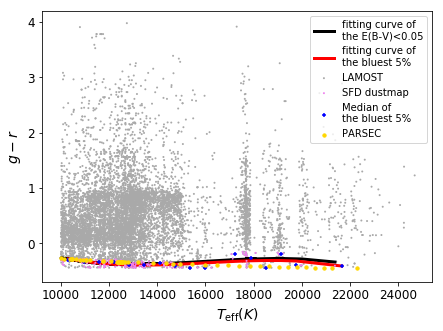

In [172]:
#PLT
plt.figure(1,figsize=(7, 5))  
plt.xlabel('$T_\mathrm{eff}(K)$',fontsize=14)
plt.ylabel(ylabel,fontsize=14)
#plt.ylim(-4,9)

# the data we use
plt.scatter(starcatalog_fram_fil[teff], starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],\
            c='darkgray',s=4, edgecolors='None',label='LAMOST')

# data we use in the SFD dustmap
plt.scatter(SFD_catalog_teff,SFD_catalog_color,alpha=1,edgecolors='None',c='violet',s=4,label='SFD dustmap',zorder=2)

# SFD fitcurve
plt.plot(SFD_catalog_teff, SFD_vals, c='black',linewidth = 3.,label='fitting curve of \nthe E(B-V)<0.05',zorder=1)

# ic plot from blue edge
plt.plot(int_teff, colorvals, c='r',linewidth = 3.,label='fitting curve of \nthe bluest 5%',zorder=1)

# ic from blue edge
plt.scatter(int_teff, int_color, edgecolors='None',c='b', marker = '+',s=11,label='Median of\nthe bluest 5%',zorder=2)

# ic from Allen's work 
# plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='lime',s=11,label='Allen',zorder=2)

# ic from parsec
plt.scatter(parsec_teff,parsec_color,c='gold',s=11,label='PARSEC',zorder=2)

### Draw the plot

# plt.xlabel('$T_\mathrm{eff}$'); plt.ylabel(ylabel)
#plt.scatter(BBFrame_fil['Teff'],BBFrame_fil['J-H'],c='#FF6666',s=11,label='Allen')

plt.legend(loc='upper right')
#new_ticks = np.linspace(-1,2,7)
#plt.yticks(new_ticks)
# plt.ylim(np.min(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]) - 0.5,\
#         np.max(starcatalog_fram_fil[color1] - starcatalog_fram_fil[color2]))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig(savename1,dpi=200)
plt.savefig(savename5,dpi=200)
plt.show()

### some other features

5


TypeError: data() missing 1 required positional argument: 'ratio_SFD'

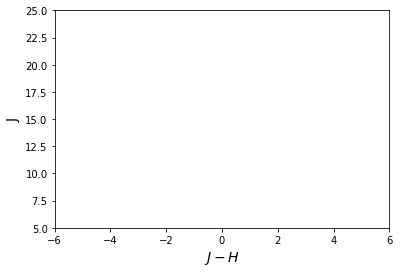

In [84]:
# H-R 1
plt.figure(2)
plt.xlabel(ylabel,fontsize=14); plt.ylabel(cc1,fontsize=14)
plt.xlim(-6,6)
plt.ylim(5,25)
# for rat in ratio:
print(rat)
int_teff,int_color,data_final = data(teff_start,rat,low_crit)

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(origin[color1]-origin[color2], origin[color1],\
            c= 'darkgray',s=5,edgecolors = 'None',alpha = 1,cmap=cm,label='all sources')
plt.scatter(data_final[color1]-data_final[color2], data_final[color1],\
             c='g',s=5, edgecolors='None', alpha=1,label='selected sources')
#plt.colorbar(sc)
plt.legend(loc='upper right')
# new_ticks = np.linspace(-2,3,18)
# plt.xticks(new_ticks)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(savename2,dpi=200)    
plt.show()

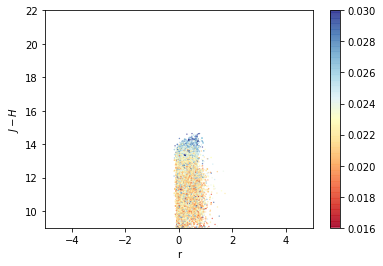

In [43]:
# 赫罗图 2
plt.xlabel('r')
plt.ylabel(ylabel)

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(starcatalog_fram_fil[color1]-starcatalog_fram_fil[color2],starcatalog_fram_fil[color1],\
            c = starcatalog_fram_fil[err_c1],s=2,edgecolors = 'None',alpha = 0.7,cmap=cm)

plt.colorbar(sc)

plt.xlim(-5,5)
plt.ylim(9,22)
plt.savefig(save+'HR.png',dpi=200)
plt.show()

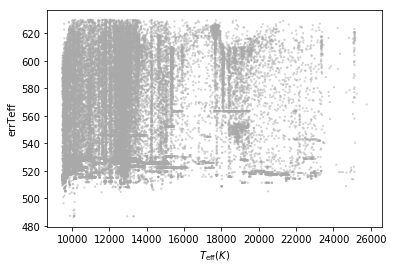

In [44]:
plt.figure(3)
plt.xlabel('$T_\mathrm{eff}(K)$')
plt.ylabel('errTeff')
plt.scatter(starcatalog_fram_fil[teff],starcatalog_fram_fil[err_teff],\
            c='darkgray',s=5, edgecolors='None', alpha=0.5)
plt.show()